# **The Best Neighborhood in New York City**

## Import Initial Necessary Packages

In [3]:
!pip install geopy
print("Installed!")

Installed!


In [4]:
!pip install folium
print("Installed!")

Installed!


In [5]:
import numpy as np
import pandas as pd 
import json 
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


## Let's Take a look at our Neighborhood Data:

### Downloading and making New York City Data into a Dataframe

In [6]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [7]:
with open('newyork_data.json') as json_data:
    json = json.load(json_data)

In [8]:
neighborhoods_data = json['features']

In [58]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [9]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

newyork_data = pd.DataFrame(columns=column_names)

In [10]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_data = newyork_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [12]:
newyork_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(newyork_data['Borough'].unique()),
        newyork_data.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [12]:
newyork_grouped = newyork_data.groupby('Borough').mean().reset_index()
newyork_grouped

,Borough,Latitude,Longitude
0,Bronx,40.850482,-73.873442
1,Brooklyn,40.651089,-73.952999
2,Manhattan,40.762438,-73.975329
3,Queens,40.706424,-73.824131
4,Staten Island,40.588851,-74.137414


### Getting the Coordinates of NYC using GeoLocator

In [69]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### To start us off, below shows the map shows all the neighborhoods and boroughs in NYC

In [14]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, neighborhood in zip(newyork_data['Latitude'], newyork_data['Longitude'], newyork_data['Borough'], newyork_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## To downsize our decision to 3 Boroughs, let's take a look at the Crime numbers:

### Let's Import and take a look at our crime dataset

In [15]:
body = client_002d83af1aa7413cbeb696fdd76629f2.get_object(Bucket='ibmcapstoneproject-donotdelete-pr-nkok2xghx2knxf',Key='crimes.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,466502077,75,BROOKLYN,03/30/2020,17:30:00,03/31/2020,06:53:00,COMPLETED,NaN,NaN,...,NaN,NaN,25-44,BLACK,M,1018496,178657,40.656991,-73.876574,"(40.65699087900003, -73.87657444799999)"
1,303191835,77,BROOKLYN,03/28/2020,19:30:00,03/28/2020,20:30:00,COMPLETED,NaN,NaN,...,M,NaN,<18,UNKNOWN,F,1003606,185050,40.674583,-73.930222,"(40.67458330800008, -73.93022154099998)"
2,735488557,43,BRONX,03/29/2020,14:10:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,NaN,UNKNOWN,UNKNOWN,D,1019853,241853,40.830443,-73.871349,"(40.83044253800006, -73.871349147)"
3,315962428,40,BRONX,03/29/2020,07:10:00,03/29/2020,07:16:00,COMPLETED,NaN,NaN,...,M,NaN,25-44,WHITE HISPANIC,F,1007236,237260,40.817878,-73.916957,"(40.817877907000025, -73.91695668199996)"
4,165437868,114,QUEENS,03/27/2020,13:15:00,03/27/2020,14:00:00,COMPLETED,NaN,NaN,...,NaN,NaN,45-64,BLACK,F,1002018,213258,40.752011,-73.935872,"(40.75201086000004, -73.93587196099996)"


### We only need the Borough and Coordinates column. So, let's make a new dataframe with only the necessary data.

In [16]:
crimes_data = df[['BORO_NM','Latitude','Longitude']]
crimes_data.head(10)

,BORO_NM,Latitude,Longitude
0,BROOKLYN,40.656991,-73.876574
1,BROOKLYN,40.674583,-73.930222
2,BRONX,40.830443,-73.871349
3,BRONX,40.817878,-73.916957
4,QUEENS,40.752011,-73.935872
5,BRONX,40.825907,-73.821328
6,BRONX,40.840977,-73.899175
7,BROOKLYN,40.663914,-73.950977
8,BRONX,40.833059,-73.929802
9,BRONX,40.889138,-73.862020


In [17]:
crimes_data.shape

(108058, 3)

### Now let's take a look at  how many crimes was reported for each Borough

In [18]:
crimes_grouped= crimes_data.groupby('BORO_NM').count().reset_index()
del crimes_grouped['Longitude']

In [19]:
crimes_grouped.columns = ['Borough','Total']

In [20]:
crimes_grouped

,Borough,Total
0,BRONX,23409
1,BROOKLYN,31028
2,MANHATTAN,26911
3,QUEENS,22098
4,STATEN ISLAND,4535


### Let's combine the total count of crimes with the average coordinates of these crimes

In [21]:
crimes_coord= crimes_data.groupby('BORO_NM').mean().reset_index()
crimes_coord

,BORO_NM,Latitude,Longitude
0,BRONX,40.844809,-73.888159
1,BROOKLYN,40.659565,-73.946828
2,MANHATTAN,40.772740,-73.969777
3,QUEENS,40.713660,-73.833165
4,STATEN ISLAND,40.602754,-74.125905


In [22]:
crimes_combined = crimes_grouped.join(crimes_coord.set_index('BORO_NM'), on = 'Borough')
crimes_combined

,Borough,Total,Latitude,Longitude
0,BRONX,23409,40.844809,-73.888159
1,BROOKLYN,31028,40.659565,-73.946828
2,MANHATTAN,26911,40.772740,-73.969777
3,QUEENS,22098,40.713660,-73.833165
4,STATEN ISLAND,4535,40.602754,-74.125905


### Let's visualize  the data in a Bubble Map form

In [23]:
map_newyork_crime = folium.Map(location=[latitude, longitude], zoom_start=11)

folium.Circle(
    radius=crimes_combined.iloc[0,1]/10,
    location=[crimes_combined.iloc[0,2],crimes_combined.iloc[0,3]],
    popup='{}, Crimes: {}'.format(crimes_combined.iloc[0,0],crimes_combined.iloc[0,1]) ,
    color='crimson',
    fill=True,
).add_to(map_newyork_crime)

folium.Circle(
    radius=crimes_combined.iloc[1,1]/10,
    location=[crimes_combined.iloc[1,2],crimes_combined.iloc[1,3]],
    popup='{}, Crimes: {}'.format(crimes_combined.iloc[1,0],crimes_combined.iloc[1,1]),
    color='Blue',
    fill=True,
).add_to(map_newyork_crime)

folium.Circle(
    radius=crimes_combined.iloc[2,1]/10,
    location=[crimes_combined.iloc[2,2],crimes_combined.iloc[2,3]],
    popup='{}, Crimes: {}'.format(crimes_combined.iloc[2,0],crimes_combined.iloc[2,1]),
    color='Orange',
    fill=True,
).add_to(map_newyork_crime)

folium.Circle(
    radius=crimes_combined.iloc[3,1]/10,
    location=[crimes_combined.iloc[3,2],crimes_combined.iloc[3,3]],
    popup='{}, Crimes: {}'.format(crimes_combined.iloc[3,0],crimes_combined.iloc[3,1]),
    color='Green',
    fill=True,
).add_to(map_newyork_crime)

folium.Circle(
    radius=crimes_combined.iloc[4,1]/10,
    location=[crimes_combined.iloc[4,2],crimes_combined.iloc[4,3]],
    popup='{}, Crimes: {}'.format(crimes_combined.iloc[4,0],crimes_combined.iloc[4,1]),
    color='Black',
    fill=True,
).add_to(map_newyork_crime)

map_newyork_crime

As seen in the Bubble Map above, we can clearly see that the boroughs with the least number of crimes reported in the NYPD system was:

1. Staten Island with 4535 Crimes
2. Queens with 22098 Crimes
3. Bronx with 23409 Crimes


## Now, let us take a look at the Subsidized Housing Property prices:

In [25]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

body = client_002d83af1aa7413cbeb696fdd76629f2.get_object(Bucket='ibmcapstoneproject-donotdelete-pr-nkok2xghx2knxf',Key='housing.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df1 = pd.read_csv(body)
df1.head()


,cartodb_id,bbl,tract_10,sba_name,ccd_name,cd_name,boro_name,city_name,tax_delinquency,ser_violation,assessed_value,owner_name,res_units,year_built,buildings,standard_address
0,4188973,2026220048,3.600502e+10,Morrisania/Belmont,City Council District 16,BX 03 - Morrisania/Crotona,Bronx,New York City,NaN,NaN,217503,BR AFFORDABLE HSINGL.,10.0,1910.0,1.0,1056 Boston Road
1,4189047,2027090034,3.600501e+10,Mott Haven/Hunts Point,City Council District 17,BX 02 - Hunts Point/Longwood,Bronx,New York City,NaN,NaN,157627,RESTORING COMMUNITIES,8.0,1907.0,1.0,847 Fox Street
2,4189053,2027530026,3.600501e+10,Morrisania/Belmont,City Council District 17,BX 03 - Morrisania/Crotona,Bronx,New York City,NaN,1.0,288000,MBD SILVA TAYLOR HOUS,23.0,1912.0,1.0,1160 Bryant Avenue
3,4189071,2027620051,3.600501e+10,Mott Haven/Hunts Point,City Council District 17,BX 02 - Hunts Point/Longwood,Bronx,New York City,NaN,1.0,395100,HUNTS POINT HSNG DEVF,32.0,1929.0,1.0,1220 Seneca Avenue
4,4189219,2028160001,3.600502e+10,Highbridge/South Concourse,City Council District 16,BX 04 - Highbridge/Concourse,Bronx,New York City,1.0,1.0,1404900,BRONX PRESERVATION HO,43.0,1923.0,1.0,1294 Grant Avenue


### We only need the Borough Units, and Value columns. So, let's make a new dataframe with only these data.

In [26]:
housing_data = df1[['boro_name','res_units','assessed_value']]
housing_data.columns = ['Borough','Units','Value ($)']
housing_data.head(10)

,Borough,Units,Value ($)
0,Bronx,10.0,217503
1,Bronx,8.0,157627
2,Bronx,23.0,288000
3,Bronx,32.0,395100
4,Bronx,43.0,1404900
5,Bronx,26.0,709650
6,Bronx,NaN,952650
7,Bronx,86.0,1776600
8,Bronx,48.0,567450
9,Bronx,1654.0,48181500


### Now let's try to get the average price per unit in each Borough

In [27]:
housing_grouped = housing_data.groupby('Borough').sum()
housing_grouped 

,Units,Value ($)
Borough,,
Bronx,255029.0,6136922401
Brooklyn,281431.0,12515538172
Manhattan,272474.0,25336230468
Queens,170411.0,7256972015
Staten Island,12163.0,383984885


In [28]:
housing_grouped['Per Unit'] = round(housing_grouped['Value ($)']/housing_grouped['Units'])

In [29]:
housing_grouped = housing_grouped.sort_values(by='Per Unit', ascending=False).reset_index()
housing_grouped

,Borough,Units,Value ($),Per Unit
0,Manhattan,272474.0,25336230468,92986.0
1,Brooklyn,281431.0,12515538172,44471.0
2,Queens,170411.0,7256972015,42585.0
3,Staten Island,12163.0,383984885,31570.0
4,Bronx,255029.0,6136922401,24064.0


In [30]:
housing_combined = newyork_grouped.join(housing_grouped.set_index('Borough'), on = 'Borough')
housing_combined

,Borough,Latitude,Longitude,Units,Value ($),Per Unit
0,Bronx,40.850482,-73.873442,255029.0,6136922401,24064.0
1,Brooklyn,40.651089,-73.952999,281431.0,12515538172,44471.0
2,Manhattan,40.762438,-73.975329,272474.0,25336230468,92986.0
3,Queens,40.706424,-73.824131,170411.0,7256972015,42585.0
4,Staten Island,40.588851,-74.137414,12163.0,383984885,31570.0


### Now, we can visualize the average unit housing prices of the Boroughs in a map form:

In [31]:
map_newyork_housing = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, size in zip(housing_combined['Latitude'], housing_combined['Longitude'], housing_combined['Borough'], housing_combined['Per Unit']):
    label = '{}, Housing Prices per Unit: {}'.format(borough, size)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size/1500,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork_housing)  
    
map_newyork_housing


### Let's compare the Housing prices and Crime Numbers for each Borough in a bar chart and see what we can observe:

In [32]:
housing_perunit=housing_combined[['Borough','Per Unit']]
housing_perunit= housing_perunit.sort_values(by='Per Unit', ascending=True)
housing_perunit['Borough'] = housing_perunit['Borough'].str.upper() 
housing_perunit=housing_perunit.set_index('Borough')
housing_perunit

,Per Unit
Borough,
BRONX,24064.0
STATEN ISLAND,31570.0
QUEENS,42585.0
BROOKLYN,44471.0
MANHATTAN,92986.0


In [33]:
crimes_grouped1 = crimes_grouped.set_index('Borough')
crimes_grouped1 = crimes_grouped1.sort_values(by='Total', ascending=True)
crimes_grouped1

,Total
Borough,
STATEN ISLAND,4535
QUEENS,22098
BRONX,23409
MANHATTAN,26911
BROOKLYN,31028


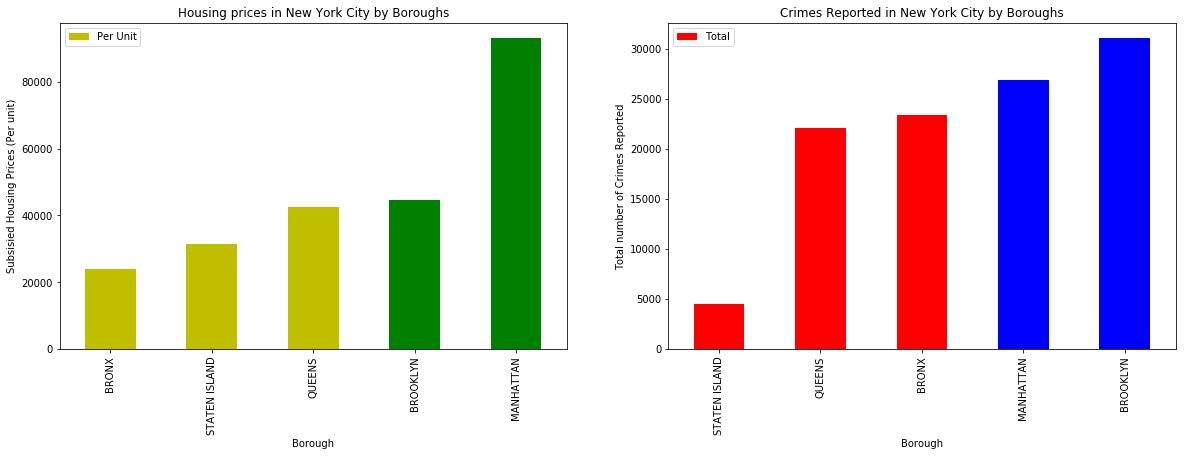

In [50]:
fig = plt.figure()

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

housing_perunit.plot(kind='bar', color='yyygg', figsize=(20, 6), ax=ax0)
ax0.set_xlabel('Borough') 
ax0.set_ylabel('Subsisied Housing Prices (Per unit)') 
ax0.set_title('Housing prices in New York City by Boroughs')

crimes_grouped1.plot(kind='bar', color='rrrbb' ,figsize=(20, 6), ax=ax1)
ax1.set_xlabel('Borough') 
ax1.set_ylabel('Total number of Crimes Reported') 
ax1.set_title('Crimes Reported in New York City by Boroughs')


plt.show()


The lower the Unit price of housing, the more attarctive it would be for migrants who is trying to save money. We can see a common pattern here between the lowest housing prices and crimes rates. The lowest ranking corough for both categories are still:

* Staten Island 
* Queens
* Bronx

Although this does not cut down our choses of the Best Borough in New York City from our initial analysis with the Crime data, this clearly affirms that the top three best boroughs in terms of safety and housing prices is the ones stated above.

However, to futher deep dive into our analysis, we should consider the different priorities of different groups of migrants. Some may Place more Importance on lower prices, and others may be safety. Thus, we will make 2 groups of people for 2 different recommendations:

* #### **Staten Island**: Safety Concious
* #### **Bronx**: Price Concious

## The last criteria we will be looking at will be the Venues surrounding the neighborhoods:

Since we would not know the preference of individual people or families migrating, whether they wish to have more parks in the vicinity or food places. 

With this issue, we will mostly judge the neighborhoods in terms of the most Venues surrounding them, and not the type. This will ensure that the migrants will have a relatively good lifestyle around the neighborhood. 

However, we will still be able to recommend different neighborhoods that offer's a relatively different kinds of lifestyles depending on the kind of venues is grouped within the most pre-dominant clusters.

### First let's define our FourSquare credentials

In [81]:
CLIENT_ID = '33QVREYP3AYXNM1P4OOSOLGIA5HB5IBRWBDCALVNNVDZUUQT' # your Foursquare ID
CLIENT_SECRET = '2GPPUATARRAF1J4RGDPMHYXKAUOI4XAM044TGJERLBZJIRBX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 33QVREYP3AYXNM1P4OOSOLGIA5HB5IBRWBDCALVNNVDZUUQT
CLIENT_SECRET:2GPPUATARRAF1J4RGDPMHYXKAUOI4XAM044TGJERLBZJIRBX


### Let's get the coordinates of the 3 Boroughs

In [67]:
address = 'Staten Island, New York City'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_SI = location.latitude
longitude_SI = location.longitude
print('The geograpical coordinate of Staten Island are {}, {}.'.format(latitude_SI, longitude_SI))

The geograpical coordinate of Staten Island are 40.564209, -74.12530461995391.


In [247]:
address = 'Bronx, New York City'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_B = location.latitude
longitude_B = location.longitude
print('The geograpical coordinate of Bronx are {}, {}.'.format(latitude_B, longitude_B))

The geograpical coordinate of Bronx are 40.8466508, -73.8785937.


### First Create our function to repeat to all neighbourhoods in our chosen Boroughs:

In [74]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## A. Staten Island: Safety Concious Migrants

### Let's retrive all the Venues for Staten Island

In [87]:
statenisland_data = newyork_data[newyork_data['Borough'] == 'Staten Island'].reset_index(drop=True)
statenisland_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


In [88]:
statenisland_venues = getNearbyVenues(names=statenisland_data['Neighborhood'],
                                   latitudes=statenisland_data['Latitude'],
                                   longitudes=statenisland_data['Longitude']
                                  )


St. George
New Brighton
Stapleton
Rosebank
West Brighton
Grymes Hill
Todt Hill
South Beach
Port Richmond
Mariner's Harbor
Port Ivory
Castleton Corners
New Springville
Travis
New Dorp
Oakwood
Great Kills
Eltingville
Annadale
Woodrow
Tottenville
Tompkinsville
Silver Lake
Sunnyside
Park Hill
Westerleigh
Graniteville
Arlington
Arrochar
Grasmere
Old Town
Dongan Hills
Midland Beach
Grant City
New Dorp Beach
Bay Terrace
Huguenot
Pleasant Plains
Butler Manor
Charleston
Rossville
Arden Heights
Greenridge
Heartland Village
Chelsea
Bloomfield
Bulls Head
Richmond Town
Shore Acres
Clifton
Concord
Emerson Hill
Randall Manor
Howland Hook
Elm Park
Manor Heights
Willowbrook
Sandy Ground
Egbertville
Prince's Bay
Lighthouse Hill
Richmond Valley
Fox Hills


In [89]:
statenisland_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. George,40.644982,-74.079353,A&S Pizzeria,40.643940,-74.077626,Pizza Place
1,St. George,40.644982,-74.079353,Beso,40.643306,-74.076508,Tapas Restaurant
2,St. George,40.644982,-74.079353,Staten Island September 11 Memorial,40.646767,-74.076510,Monument / Landmark
3,St. George,40.644982,-74.079353,Richmond County Bank Ballpark,40.645056,-74.076864,Baseball Stadium
4,St. George,40.644982,-74.079353,Shake Shack,40.643660,-74.075891,Burger Joint


In [90]:
print('There are {} uniques Venues in Staten Island.'.format(len(statenisland_venues['Venue Category'].unique())))

There are 173 uniques Venues in Staten Island.


In [104]:
statenisland_numvenues=statenisland_venues.groupby('Neighborhood').count().reset_index()
statenisland_numvenues = statenisland_numvenues[['Neighborhood','Venue']]
statenisland_numvenues.columns = ['Neighborhood','Total Venues']
statenisland_numvenues.head()

,Neighborhood,Total Venues
0,Annadale,11
1,Arden Heights,5
2,Arlington,5
3,Arrochar,21
4,Bay Terrace,13


### We make use of one-hot coding to analyse the Neighborhoods individually and group them

In [96]:
statenisland_onehot = pd.get_dummies(statenisland_venues[['Venue Category']], prefix="", prefix_sep="")

statenisland_onehot['Neighborhood'] = statenisland_venues['Neighborhood'] 

fixed_columns = [statenisland_onehot.columns[-1]] + list(statenisland_onehot.columns[:-1])
statenisland_onehot = statenisland_onehot[fixed_columns]

statenisland_grouped = statenisland_onehot.groupby('Neighborhood').mean().reset_index()

statenisland_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Tourist Information Center,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0
1,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Arlington,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Arrochar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Bay Terrace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0


### Now we can find out the Top 5 Most common Venue Category in each Neighborhood!

In [97]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [224]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']


columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

        
statenisland_venues_sorted = pd.DataFrame(columns=columns)
statenisland_venues_sorted['Neighborhood'] = statenisland_grouped['Neighborhood']

for ind in np.arange(statenisland_grouped.shape[0]):
    statenisland_venues_sorted.iloc[ind, 1:] = return_most_common_venues(statenisland_grouped.iloc[ind, :], num_top_venues)


statenisland_venues_sorted = statenisland_numvenues.join(statenisland_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
statenisland_venues_sorted = statenisland_venues_sorted.sort_values('Total Venues',ascending=False).reset_index(drop=True)

statenisland_venues_sorted.head()

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bulls Head,43,Pizza Place,Chinese Restaurant,Bus Stop,Café,Pharmacy
1,West Brighton,42,Coffee Shop,Italian Restaurant,Music Store,Breakfast Spot,Bank
2,Eltingville,37,Pizza Place,Sushi Restaurant,Pharmacy,Fast Food Restaurant,Bank
3,Stapleton,33,Discount Store,Restaurant,Bar,Bank,New American Restaurant
4,St. George,31,Clothing Store,Bar,Sporting Goods Shop,Italian Restaurant,Park


### Now let's cluster the Staten Island Neighborhoods.

In [240]:
kclusters = 5

statenisland_grouped_clustering = statenisland_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(statenisland_grouped_clustering)

kmeans.labels_ 

array([0, 3, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3,
       0, 0, 2, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 1, 3, 0, 3, 0,
       0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 4, 3, 0], dtype=int32)

In [226]:
statenisland_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [227]:
statenisland_venues_sorted.head()

,Cluster Labels,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Bulls Head,43,Pizza Place,Chinese Restaurant,Bus Stop,Café,Pharmacy
1,3,West Brighton,42,Coffee Shop,Italian Restaurant,Music Store,Breakfast Spot,Bank
2,3,Eltingville,37,Pizza Place,Sushi Restaurant,Pharmacy,Fast Food Restaurant,Bank
3,0,Stapleton,33,Discount Store,Restaurant,Bar,Bank,New American Restaurant
4,0,St. George,31,Clothing Store,Bar,Sporting Goods Shop,Italian Restaurant,Park


### Let's prepare the data for clustering.

In [228]:
statenisland_merged = statenisland_data
statenisland_merged = statenisland_merged.join(statenisland_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
statenisland_merged = statenisland_merged[statenisland_merged['Cluster Labels'].notna()]
statenisland_merged ['Cluster Labels'] = statenisland_merged ['Cluster Labels'].astype(int)
print(statenisland_merged.shape)
statenisland_merged.head()

(62, 11)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Staten Island,St. George,40.644982,-74.079353,0,31.0,Clothing Store,Bar,Sporting Goods Shop,Italian Restaurant,Park
1,Staten Island,New Brighton,40.640615,-74.087017,0,12.0,Bus Stop,Deli / Bodega,Park,Discount Store,Bowling Alley
2,Staten Island,Stapleton,40.626928,-74.077902,0,33.0,Discount Store,Restaurant,Bar,Bank,New American Restaurant
3,Staten Island,Rosebank,40.615305,-74.069805,3,27.0,Grocery Store,Italian Restaurant,Mexican Restaurant,Pizza Place,Cajun / Creole Restaurant
4,Staten Island,West Brighton,40.631879,-74.107182,3,42.0,Coffee Shop,Italian Restaurant,Music Store,Breakfast Spot,Bank


In [243]:
map_SI_clusters = folium.Map(location=[latitude_SI, longitude_SI], zoom_start=12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(statenisland_merged['Latitude'], statenisland_merged['Longitude'], statenisland_merged['Neighborhood'], statenisland_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_SI_clusters)
       
map_SI_clusters


#### Cluster 0:

In [244]:
statenisland_merged.loc[statenisland_merged['Cluster Labels'] == 0, statenisland_merged.columns[[1] + list(range(5, statenisland_merged.shape[1]))]].sort_values(by='Total Venues', ascending=False)


,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
46,Bulls Head,43.0,Pizza Place,Chinese Restaurant,Bus Stop,Café,Pharmacy
2,Stapleton,33.0,Discount Store,Restaurant,Bar,Bank,New American Restaurant
0,St. George,31.0,Clothing Store,Bar,Sporting Goods Shop,Italian Restaurant,Park
39,Charleston,28.0,Big Box Store,Cosmetics Shop,Donut Shop,Hardware Store,Business Service
14,New Dorp,25.0,Italian Restaurant,Pizza Place,Chinese Restaurant,Taco Place,Dim Sum Restaurant
48,Shore Acres,23.0,Italian Restaurant,Bus Stop,Intersection,Deli / Bodega,Bar
33,Grant City,23.0,Pizza Place,Fast Food Restaurant,Bar,French Restaurant,Food & Drink Shop
21,Tompkinsville,22.0,Brewery,Recording Studio,Sandwich Place,Food Truck,Spanish Restaurant
31,Dongan Hills,21.0,Italian Restaurant,Pizza Place,Deli / Bodega,Jewelry Store,Tattoo Parlor
28,Arrochar,21.0,Pizza Place,Italian Restaurant,Deli / Bodega,Bus Stop,Hotel


#### Cluster 1:

In [231]:
statenisland_merged.loc[statenisland_merged['Cluster Labels'] == 1, statenisland_merged.columns[[1] + list(range(5, statenisland_merged.shape[1]))]]

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
38,Butler Manor,6.0,Pool,Baseball Field,Convenience Store,Bus Stop,Yoga Studio


#### Cluster 2:

In [232]:
statenisland_merged.loc[statenisland_merged['Cluster Labels'] == 2, statenisland_merged.columns[[1] + list(range(5, statenisland_merged.shape[1]))]]

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
35,Bay Terrace,13.0,Supermarket,Italian Restaurant,Insurance Office,Shipping Store,Sushi Restaurant


#### Cluster 3:

In [246]:
statenisland_merged.loc[statenisland_merged['Cluster Labels'] == 3, statenisland_merged.columns[[1] + list(range(5, statenisland_merged.shape[1]))]].sort_values(by='Total Venues', ascending=False)

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,West Brighton,42.0,Coffee Shop,Italian Restaurant,Music Store,Breakfast Spot,Bank
17,Eltingville,37.0,Pizza Place,Sushi Restaurant,Pharmacy,Fast Food Restaurant,Bank
12,New Springville,28.0,Deli / Bodega,Pizza Place,Chinese Restaurant,Coffee Shop,Mobile Phone Shop
3,Rosebank,27.0,Grocery Store,Italian Restaurant,Mexican Restaurant,Pizza Place,Cajun / Creole Restaurant
29,Grasmere,23.0,Bus Stop,Bagel Shop,Bank,Ice Cream Shop,Flower Shop
49,Clifton,20.0,Grocery Store,Train Station,Electronics Store,Bakery,Taco Place
19,Woodrow,19.0,Donut Shop,Bank,Chinese Restaurant,Gift Shop,Coffee Shop
11,Castleton Corners,15.0,Pizza Place,Thai Restaurant,Bagel Shop,Grocery Store,Mini Golf
43,Heartland Village,11.0,Coffee Shop,Accessories Store,Optical Shop,Restaurant,Donut Shop
59,Prince's Bay,9.0,Pizza Place,Chinese Restaurant,Sushi Restaurant,Liquor Store,Tanning Salon


#### Cluster 4:

In [245]:
statenisland_merged.loc[statenisland_merged['Cluster Labels'] == 4, statenisland_merged.columns[[1] + list(range(5, statenisland_merged.shape[1]))]]

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
25,Westerleigh,2.0,Arcade,Convenience Store,Yoga Studio,Farmers Market,Furniture / Home Store


#### Cluster 5:

In [235]:
statenisland_merged.loc[statenisland_merged['Cluster Labels'] == 5, statenisland_merged.columns[[1] + list(range(5, statenisland_merged.shape[1]))]]

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


## Staten Island Observations

With our observation of the clusters above, we can scrape Clusters 1, 2, 4 and 5 as they either do not cointain any neighborhoods or they have insuffficient venues within the neighborhood vicinity.

Now, let's look more into Clusters 0 and 3 and observe the Venue Categories that differs them.

### **Cluster 1**

In [336]:
cluster0 = statenisland_merged.loc[statenisland_merged['Cluster Labels'] == 0, statenisland_merged.columns[[1] + list(range(5, statenisland_merged.shape[1]))]].sort_values(by='Total Venues', ascending=False)
cluster0_count=statenisland_onehot[statenisland_onehot['Neighborhood'].isin(cluster0['Neighborhood'].tolist())].groupby('Neighborhood').sum().reset_index().sum().to_frame()
cluster0_count.columns=['Total Venues']
cluster0_count=cluster0_count[1:].sort_values(by='Total Venues', ascending=False)
cluster0_count.head(10)


,Total Venues
Pizza Place,35
Deli / Bodega,32
Bus Stop,31
Italian Restaurant,31
Chinese Restaurant,13
Bar,12
Sandwich Place,12
Bagel Shop,12
Cosmetics Shop,11
Donut Shop,11


### **Cluster 3**

In [334]:
cluster3 = statenisland_merged.loc[statenisland_merged['Cluster Labels'] == 3, statenisland_merged.columns[[1] + list(range(5, statenisland_merged.shape[1]))]].sort_values(by='Total Venues', ascending=False)
cluster3_count=statenisland_onehot[statenisland_onehot['Neighborhood'].isin(cluster3['Neighborhood'].tolist())].groupby('Neighborhood').sum().reset_index().sum().to_frame()
cluster3_count.columns=['Total Venues']
cluster3_count=cluster3_count[1:].sort_values(by='Total Venues', ascending=False)
cluster3_count.head(10)

,Total Venues
Pizza Place,19
Bus Stop,12
Grocery Store,11
Pharmacy,10
Bagel Shop,10
Coffee Shop,10
Italian Restaurant,9
Sandwich Place,8
Bank,8
Bar,7


From our analysis of the top Venues in each cluster, it seems the differing venues is that Cluster 0 is mainly a Food District with more Food places in its neighborhoods. As for Cluster 3, it also has a lot of food places, however, this has a greater variety of venues such as Grocery stores, Pharmacy and Banks which will be greatly convinient when moving into a new area. We shall then choose the top 3 neighborhoods from this cluster with the most venues.

### **Thus, the best Neighborhoods in Staten Island are:**
    1. West Brighton
    2. Etingville
    3. New Springvilee

## B. Bronx: Price Concious Migrants

### Let's retrive all the Venues for Bronx

In [249]:
bronx_data = newyork_data[newyork_data['Borough'] == 'Bronx'].reset_index(drop=True)
bronx_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [250]:
bronx_venues = getNearbyVenues(names=bronx_data['Neighborhood'],
                                   latitudes=bronx_data['Latitude'],
                                   longitudes=bronx_data['Longitude']
                                  )


Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Claremont Village
Concourse Village
Mount Eden
Mount Hope
Bronxdale
Allerton
Kingsbridge Heights


In [251]:
bronx_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [252]:
print('There are {} uniques Venues in Bronx.'.format(len(bronx_venues['Venue Category'].unique())))

There are 174 uniques Venues in Bronx.


In [253]:
bronx_numvenues=bronx_venues.groupby('Neighborhood').count().reset_index()
bronx_numvenues = bronx_numvenues[['Neighborhood','Venue']]
bronx_numvenues.columns = ['Neighborhood','Total Venues']
bronx_numvenues.head()

,Neighborhood,Total Venues
0,Allerton,28
1,Baychester,20
2,Bedford Park,34
3,Belmont,97
4,Bronxdale,14


### We make use of one-hot coding to analyse the Neighborhoods individually and group them

In [254]:
bronx_onehot = pd.get_dummies(bronx_venues[['Venue Category']], prefix="", prefix_sep="")

bronx_onehot['Neighborhood'] = bronx_venues['Neighborhood'] 

fixed_columns = [bronx_onehot.columns[-1]] + list(bronx_onehot.columns[:-1])
bronx_onehot = bronx_onehot[fixed_columns]

bronx_grouped = bronx_onehot.groupby('Neighborhood').mean().reset_index()

bronx_grouped.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Trail,Train Station,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waste Facility,Wine Shop,Wings Joint,Women's Store
0,Allerton,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Baychester,0.05,0.0,0.000000,0.05,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Bedford Park,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Belmont,0.00,0.0,0.010309,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.010309,0.0
4,Bronxdale,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### Now we can find out the Top 5 Most common Venue Category in each Neighborhood!

In [255]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']


columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

        
bronx_venues_sorted = pd.DataFrame(columns=columns)
bronx_venues_sorted['Neighborhood'] = bronx_grouped['Neighborhood']

for ind in np.arange(bronx_grouped.shape[0]):
    bronx_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bronx_grouped.iloc[ind, :], num_top_venues)


bronx_venues_sorted = bronx_numvenues.join(bronx_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
bronx_venues_sorted = bronx_venues_sorted.sort_values('Total Venues',ascending=False).reset_index(drop=True)

bronx_venues_sorted.head()

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Belmont,97,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Donut Shop
1,Fordham,82,Mobile Phone Shop,Shoe Store,Bank,Spanish Restaurant,Donut Shop
2,Kingsbridge,67,Pizza Place,Sandwich Place,Bar,Mexican Restaurant,Latin American Restaurant
3,Pelham Bay,42,Fast Food Restaurant,Bank,Italian Restaurant,Sandwich Place,Convenience Store
4,Concourse Village,40,Mexican Restaurant,Sandwich Place,Deli / Bodega,Fast Food Restaurant,Fried Chicken Joint


### Now let's cluster the Bronx Neighborhoods.

In [256]:
kclusters = 5

bronx_grouped_clustering = bronx_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bronx_grouped_clustering)

kmeans.labels_ 

array([2, 2, 2, 1, 1, 2, 2, 4, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 4, 2, 2, 2, 1, 2, 4, 2, 2, 2, 1, 2, 4, 2, 4, 2, 1,
       2, 2, 1, 2, 4, 2, 3, 1], dtype=int32)

In [258]:
bronx_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [259]:
bronx_venues_sorted.head()

,Cluster Labels,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,2,Belmont,97,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Donut Shop
1,2,Fordham,82,Mobile Phone Shop,Shoe Store,Bank,Spanish Restaurant,Donut Shop
2,2,Kingsbridge,67,Pizza Place,Sandwich Place,Bar,Mexican Restaurant,Latin American Restaurant
3,1,Pelham Bay,42,Fast Food Restaurant,Bank,Italian Restaurant,Sandwich Place,Convenience Store
4,1,Concourse Village,40,Mexican Restaurant,Sandwich Place,Deli / Bodega,Fast Food Restaurant,Fried Chicken Joint


### Let's prepare the data for clustering.

In [260]:
bronx_merged = bronx_data
bronx_merged = bronx_merged.join(bronx_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
bronx_merged = bronx_merged[bronx_merged['Cluster Labels'].notna()]
bronx_merged ['Cluster Labels'] = bronx_merged ['Cluster Labels'].astype(int)
print(bronx_merged.shape)
bronx_merged.head()

(52, 11)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,1,9,Pharmacy,Ice Cream Shop,Donut Shop,Deli / Bodega,Dessert Shop
1,Bronx,Co-op City,40.874294,-73.829939,2,13,Ice Cream Shop,Bagel Shop,Pharmacy,Discount Store,Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,1,21,Caribbean Restaurant,Deli / Bodega,Diner,Bus Stop,Cosmetics Shop
3,Bronx,Fieldston,40.895437,-73.905643,3,4,Cosmetics Shop,High School,Bus Station,Plaza,History Museum
4,Bronx,Riverdale,40.890834,-73.912585,2,11,Park,Bus Station,Home Service,Gym,Food Truck


In [261]:
map_B_clusters = folium.Map(location=[latitude_B, longitude_B], zoom_start=12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(bronx_merged['Latitude'], bronx_merged['Longitude'], bronx_merged['Neighborhood'], bronx_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_B_clusters)
       
map_B_clusters


#### Cluster 0:

In [262]:
bronx_merged.loc[bronx_merged['Cluster Labels'] == 0, bronx_merged.columns[[1] + list(range(5, bronx_merged.shape[1]))]]

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
42,Concourse,26,Grocery Store,Pizza Place,Ice Cream Shop,Donut Shop,Chinese Restaurant


#### Cluster 1:

In [267]:
bronx_merged.loc[bronx_merged['Cluster Labels'] == 1, bronx_merged.columns[[1] + list(range(5, bronx_merged.shape[1]))]].sort_values(by='Total Venues', ascending=False)

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
36,Pelham Bay,42,Fast Food Restaurant,Bank,Italian Restaurant,Sandwich Place,Convenience Store
46,Concourse Village,40,Mexican Restaurant,Sandwich Place,Deli / Bodega,Fast Food Restaurant,Fried Chicken Joint
50,Allerton,28,Pizza Place,Chinese Restaurant,Supermarket,Deli / Bodega,Playground
19,Melrose,27,Pizza Place,Pharmacy,Sandwich Place,Discount Store,Gym / Fitness Center
2,Eastchester,21,Caribbean Restaurant,Deli / Bodega,Diner,Bus Stop,Cosmetics Shop
41,Pelham Gardens,18,Bus Station,Pharmacy,Donut Shop,Grocery Store,Spanish Restaurant
48,Mount Hope,13,Grocery Store,Ice Cream Shop,Deli / Bodega,Sandwich Place,Donut Shop
0,Wakefield,9,Pharmacy,Ice Cream Shop,Donut Shop,Deli / Bodega,Dessert Shop
28,Country Club,8,Playground,Sandwich Place,Chinese Restaurant,Athletics & Sports,Trail
8,Williamsbridge,4,Soup Place,Bar,Nightclub,Caribbean Restaurant,Women's Store


#### Cluster 2:

In [268]:
bronx_merged.loc[bronx_merged['Cluster Labels'] == 2, bronx_merged.columns[[1] + list(range(5, bronx_merged.shape[1]))]].sort_values(by='Total Venues', ascending=False)

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
33,Belmont,97,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Donut Shop
15,Fordham,82,Mobile Phone Shop,Shoe Store,Bank,Spanish Restaurant,Donut Shop
5,Kingsbridge,67,Pizza Place,Sandwich Place,Bar,Mexican Restaurant,Latin American Restaurant
47,Mount Eden,36,Pharmacy,Fast Food Restaurant,Grocery Store,Supermarket,Bar
12,Bedford Park,34,Diner,Pizza Place,Mexican Restaurant,Chinese Restaurant,Sandwich Place
30,Westchester Square,32,Fast Food Restaurant,Donut Shop,Pharmacy,Pizza Place,Sandwich Place
29,Parkchester,32,Supermarket,Pizza Place,Kids Store,American Restaurant,Mobile Phone Shop
51,Kingsbridge Heights,31,Pizza Place,Bus Station,Coffee Shop,Mexican Restaurant,School
11,City Island,29,Harbor / Marina,Seafood Restaurant,Thrift / Vintage Store,Ice Cream Shop,Park
10,Pelham Parkway,28,Deli / Bodega,Pizza Place,Chinese Restaurant,Italian Restaurant,Bus Station


#### Cluster 3:

In [347]:
bronx_merged.loc[bronx_merged['Cluster Labels'] == 3, bronx_merged.columns[[1] + list(range(5, bronx_merged.shape[1]))]].sort_values(by='Total Venues', ascending=False)


,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Fieldston,4,Cosmetics Shop,High School,Bus Station,Plaza,History Museum


#### Cluster 4:

In [271]:
bronx_merged.loc[bronx_merged['Cluster Labels'] == 4, bronx_merged.columns[[1] + list(range(5, bronx_merged.shape[1]))]].sort_values(by='Total Venues', ascending=False)

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,Norwood,32,Pizza Place,Park,Bank,Pharmacy,Chinese Restaurant
9,Baychester,20,Donut Shop,Accessories Store,Fried Chicken Joint,Pizza Place,Convenience Store
21,Port Morris,16,Furniture / Home Store,Latin American Restaurant,Cupcake Shop,Restaurant,Brewery
26,Clason Point,11,Park,Pool,Boat or Ferry,Grocery Store,Recording Studio
40,Olinville,10,Chinese Restaurant,Caribbean Restaurant,Deli / Bodega,Fried Chicken Joint,Supermarket
34,Spuyten Duyvil,8,Tennis Stadium,Scenic Lookout,Pharmacy,Intersection,Park


#### Cluster 5:

In [266]:
bronx_merged.loc[bronx_merged['Cluster Labels'] == 5, bronx_merged.columns[[1] + list(range(5, bronx_merged.shape[1]))]]

,Neighborhood,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


## Bronx Observations

With our observation of the clusters above, we can scrape Clusters 0, 3, 4 and 5 as they either do not cointain any neighborhoods or they have insuffficient venues within the neighborhood vicinity.

Now, let's look more into Clusters 1 and 2 observe the Venue Categories that differs them.

### **Cluster 1**

In [341]:
cluster1b = bronx_merged.loc[bronx_merged['Cluster Labels'] == 1, bronx_merged.columns[[1] + list(range(5, bronx_merged.shape[1]))]].sort_values(by='Total Venues', ascending=False)
cluster1b_count=bronx_onehot[bronx_onehot['Neighborhood'].isin(cluster1b['Neighborhood'].tolist())].groupby('Neighborhood').sum().reset_index().sum().to_frame()
cluster1b_count.columns=['Total Venues']
cluster1b_count=cluster1b_count[1:].sort_values(by='Total Venues', ascending=False)
cluster1b_count.head(10)



,Total Venues
Pizza Place,13
Sandwich Place,12
Deli / Bodega,11
Pharmacy,11
Donut Shop,10
Fast Food Restaurant,8
Grocery Store,6
Diner,6
Bus Station,6
Mexican Restaurant,6


### **Cluster 2**

In [342]:
cluster2b = bronx_merged.loc[bronx_merged['Cluster Labels'] == 2, bronx_merged.columns[[1] + list(range(5, bronx_merged.shape[1]))]].sort_values(by='Total Venues', ascending=False)
cluster2b_count=bronx_onehot[bronx_onehot['Neighborhood'].isin(cluster2b['Neighborhood'].tolist())].groupby('Neighborhood').sum().reset_index().sum().to_frame()
cluster2b_count.columns=['Total Venues']
cluster2b_count=cluster2b_count[1:].sort_values(by='Total Venues', ascending=False)
cluster2b_count.head(10)



,Total Venues
Pizza Place,77
Deli / Bodega,38
Italian Restaurant,32
Donut Shop,31
Bus Station,30
Pharmacy,30
Grocery Store,26
Sandwich Place,24
Bank,24
Chinese Restaurant,23


From our analysis of the top Venues in each cluster, it is clear that the variety of Venues within bothn clusters is extremely similar and will both provide a variety of lifestyle needs for the migrants. With this, we shall judge on the best neighborhood using the most venues within the vicinity, which would be Cluster 2.

### **Thus, the best Neighborhoods in Bronx are:**
    1. Belmont
    2. Fordham
    3. Kingsbridge

# Final Verdict

We have come to the conclusion that the best neighbourhoods in New York City are:

<center>

| <div style="width:290px">Staten Island</div> |<div style="width:290px">Bronx</div>                      |
|:---:|:-----:|
| Belmont           | West Brighton |
| Fordham          | Etingville |
| Kingsbridge           |New Springvilee |
    
</center>

### Bronx: 

In [364]:
cluster2bb=cluster2b[:3].set_index('Neighborhood')
cluster2bb.join(newyork_data.set_index('Neighborhood'), on = 'Neighborhood') 

,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
Neighborhood,,,,,,,,,
Belmont,97,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Donut Shop,Bronx,40.857277,-73.888452
Fordham,82,Mobile Phone Shop,Shoe Store,Bank,Spanish Restaurant,Donut Shop,Bronx,40.860997,-73.896427
Kingsbridge,67,Pizza Place,Sandwich Place,Bar,Mexican Restaurant,Latin American Restaurant,Bronx,40.881687,-73.902818


### Staten Island: 

In [366]:
cluster3b=cluster3[:3].set_index('Neighborhood')
cluster3b.join(newyork_data.set_index('Neighborhood'), on = 'Neighborhood') 

,Total Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
Neighborhood,,,,,,,,,
West Brighton,42.0,Coffee Shop,Italian Restaurant,Music Store,Breakfast Spot,Bank,Staten Island,40.631879,-74.107182
Eltingville,37.0,Pizza Place,Sushi Restaurant,Pharmacy,Fast Food Restaurant,Bank,Staten Island,40.542231,-74.164331
New Springville,28.0,Deli / Bodega,Pizza Place,Chinese Restaurant,Coffee Shop,Mobile Phone Shop,Staten Island,40.594252,-74.164960
